In [1]:
%env MKL_THREADING_LAYER=GNU
%env THEANO_FLAGS=device=cpu,floatX=float64
# optimizer=fast_run,NanGuardMode.action=warn
# use device=cuda for gpu support

env: MKL_THREADING_LAYER=GNU
env: THEANO_FLAGS=device=cpu,floatX=float64


In [2]:
import sys
from __future__ import division
add = __builtin__.sum

In [3]:
from theano import clone, function, pp, shared
from theano.tensor import (concatenate, config, cosh, dot, erfinv, eq, grad, min,
                           scalar, scalars, shape_padright, sqrt, sum, switch,
                           tensor3, tensor5, TensorType, tile, vector)
from theano.printing import debugprint, pydotprint
#from theano.tensor.shared_randomstreams import RandomStreams
# used later
from theano.tensor import roll, stack

In [4]:
from numpy import (array, arange, asarray, exp, full, Inf, linspace,
                   mean, meshgrid, pi, roll)
# used later
#from numpy import roll, stack

In [5]:
from sympy import (Abs, Eq, exp as Exp, I, init_printing, integrate,
                   oo, Matrix, pi as Pi, solve, symbols, Symbol)
#from sympy.printing.theanocode
# added erfinv
from theanocode import theano_code, theano_function
#from pymatrix import matrix, Matrix

In [6]:
init_printing() #(use_latex='mathjax')

In [7]:
from IPython.display import display, HTML, SVG

In [8]:
%matplotlib inline
#import matplotlib
from matplotlib.pyplot import (axes, close, contour, contourf, figure, legend,
                               plot, scatter, show, title, xlabel, ylabel,
                               xlim,ylim)
from matplotlib.cm import * #coolwarm, Spectral
from mpl_toolkits.mplot3d import axes3d
from matplotlib import animation

In [9]:
from sdict import select
# E.g. select({3:3.2,2:2.2})[[2,3]] or
S=select({3:3.2,2:2.2})
S[array([2,3,2,2])]

array([ 2.2,  3.2,  2.2,  2.2])

In [10]:
from smatrix import *
# E.g.
print matrix([[1,2],[3,4]]).inverse()

-2   1

 1  -1


In [11]:
# function of specified variables fun(y,...) from expression f
# where: fun(x,y)(f)(x,y) = f
def fun(*y):
    try: # theano?
        return lambda f: lambda *x: clone(f, dict([[y[i],x[i]] for i in range(len(y))]),strict=False)
    except:
        return lambda f: lambda *x: f.subs( dict([[y[i],x[i]] for i in range(len(y))]))

The multidimensional symbolic array $C$ represents a "uniformizing" mapping of worlds into configuration space, i.e. the position of each particle in each world.

In [12]:
dim = range(2) # dimension
C = TensorType(config.floatX, (False,)*(1+len(dim)))('C') # shape: d * N**d

#### Boundary Conditions

We introduce fictitious worlds, two worlds deep, at the edges of the array to represent boundary conditions. Boundry worlds can be removed or set to zero.

In [13]:
B=2
def boundary0(r):
    for i in range(r.ndim):
        rs = list(r.shape); rs[i]=1
        s = [1]*r.ndim; s[i]=B
        before1 = tile(array([0]*B,config.floatX).reshape(*s),rs)
        s = [1]*r.ndim; s[i]=B
        after1 = tile(array([0]*B,config.floatX).reshape(*s),rs)
        r = concatenate([before1,r,after1], axis=i)
    return r

In [14]:
def boundary(s): return stack([boundary0(r) for r in s])

In [15]:
def debound(r): return r[tuple([slice(B,-B)]*(r.ndim))]

In [16]:
# uniform grid between 0 and 1 of dimension d and size N
def grid(d,N):
    return array(meshgrid(*[arange(0.0+0.5/N,1.0,1.0/N,config.floatX)]*d,
                              indexing='ij'))

In [17]:
# E.g.
grid(2,2)

array([[[ 0.25,  0.25],
        [ 0.75,  0.75]],

       [[ 0.25,  0.75],
        [ 0.25,  0.75]]])

In [18]:
boundary(grid(2,2)).eval()

array([[[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.25,  0.25,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.75,  0.75,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ]],

       [[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.25,  0.75,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.25,  0.75,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ]]])

In [19]:
array(list(map(debound,boundary(grid(2,2)).eval())))

array([[[ 0.25,  0.25],
        [ 0.75,  0.75]],

       [[ 0.25,  0.75],
        [ 0.25,  0.75]]])

### Difference operator ###

In [20]:
# In the following use numpy's roll and stack. Later we will use theano for these operations.
from numpy import roll, stack

In [21]:
N=9

Symbolic grid.

In [22]:
var=['x','y']

In [24]:
xb=array(meshgrid(*[symbols(['%s_{%s}'%(var[j].replace(' ',''),str(Symbol("i")+(i-N//2)).replace(' ','')) for i in range(N)]) for j in dim],indexing='ij'))
xb.shape

In [25]:
Matrix(xb[0].tolist())

In [26]:
Matrix(xb[1].tolist())

In [27]:
xb[0,:,N//2].tolist()

In [28]:
xb[1,N//2,:].tolist()

The index of the $i^{th}$ world with boundry worlds removed:

In [29]:
x=array(map(debound,xb))

In [30]:
ith = N//2-B
x_i=x[0][ith,ith]
y_i=x[1][ith,ith]
(x_i,y_i)

Forward and backward differences

In [31]:
def d(dir,x,i):
    if dir<0:
        return roll(x, dir, axis = i) - x
    else:
        return x - roll(x, dir, axis = i)

In [32]:
debound(d(+1,xb[0],0)).tolist()

In [33]:
debound(d(-1,xb[0],0)).tolist()

Jacobian

In [34]:
def J(C): return matrix([[d(-1,C[j],i) for i in dim] for j in dim])

In [35]:
def K(C): return 1/J(C)

#### Quantum Potential (Schiff&Poirier eq. 20)####

In [36]:
hbar=Symbol('hbar') # Planck's constant

In [37]:
mu=array(symbols(['mu%s'%i for i in dim])) # mass
list(mu)

In [38]:
def Q(hbar,mu,C):
    K_C = K(C)
    return debound(add([add([add([
           -hbar**2/(4*mu[j])*(K_C[k,j]*d(-1,d(+1,K_C[l,j], k), l) + d(+1,K_C[l,j], l)*d(+1,K_C[k,j], k)/2)
                 for k in dim]) for j in dim]) for l in dim]))

The quantum potential at the $i^{th}$ world:

In [39]:
Qs=Q(hbar,mu,xb)
Qs.shape

The $i^{th}$ entry in this array is generic, i.e. independent of the worlds at the boundary.

In [40]:
Qs[ith,ith]

#### Quantum Force ####

In general the force is a vector.
Provided the number of worlds is large enough the trace of Q contains sufficient information to compute gradients.

In [41]:
QU=add([Qs[i,i] for i in range(N-2*B)]) # trace

In [42]:
R0 = -QU.diff(x_i); R0

In [43]:
R1 = -QU.diff(y_i); R1

These are the same expressions in different variables! If we have computed the gradients properly this means that the quantum force is "separable".  The forces on each axis (orthogonal directions) are independent of each other. Therefore the generalization to higher dimensions/multiple particles is essentially trivial.

 Schiff & Poirier eq 18

In [44]:
def R(hbar,mu,C):
    K_C=K(C)
    return stack([debound(add([add([add([add([
      hbar**2/(4*mu[j])*d(+1,K_C[k, i]*K_C[p, j]*d(-1,d(+1,K_C[l, j], k), l), p)
        for p in dim]) for k in dim]) for j in dim]) for l in dim]))
            for i in dim])

In [45]:
Rs=R(hbar,mu,xb)
Rs.shape

Again, the $i^{th}$ entry in these arrays are generic, i.e. independent of the boundary worlds.

In [46]:
Rs[0,ith,ith]

In [47]:
Rs[1,ith,ith]

As expected, the discretized Schiff and Poirier expression for the quantum force is the gradient of the discretized quantum potential.

In [48]:
print Rs[0,ith,ith].expand()==R0.expand()
print Rs[1,ith,ith].expand()==R1.expand()

True
True


It is also interesting to note that the gradient of a simpler potential, which differs from the $2^{nd}$ order term in Schiff&Poirier eq. 20 by only the sign, yields the same expression for the quantum force. This turns out to be the same quantum potential as introduced by Hall&Deckart.

In [49]:
def Q2(hbar,mu,C):
    K_C = K(C)
    return debound(add([add([add([
           hbar**2/(8*mu[j])*d(+1,K_C[l,j], l)*d(+1,K_C[k,j], k)
                 for k in dim]) for j in dim]) for l in dim]))

In [50]:
Qs2=Q2(hbar,mu,xb)

The discretized version of this expression is identical to that introduced by Hall & Deckart.

In [51]:
Qs2[ith,ith]

Gradient of the trace.

In [52]:
Q2R0 = -add([Qs2[i,i] for i in range(N-2*B)]).diff(x_i)
Q2R1 = -add([Qs2[i,i] for i in range(N-2*B)]).diff(y_i)

In [54]:
((Rs[0,ith,ith] - Q2R0).simplify()==0 and
 (Rs[1,ith,ith] - Q2R1).simplify()==0)

True

### Numeric computation ###

These expressions can be converted directly to Theano functions for efficient execution on gpu and multicore processors.

In [55]:
from theano.tensor import roll, stack

In [56]:
hbar_s = theano_code(hbar)
mu_v = vector('mu')

Without sympy simplification Theano would produce the following expressions (disabled below since they are not needed in this worksheet):

$3^{rd}$ order potential

In [57]:
#Q_=function([hbar_s,mu_v,C],Q(hbar_s,mu_v,C))
#pp(Q_.maker.fgraph.outputs[0])

$2^{nd}$ order potential

In [58]:
#Q2_=function([hbar_s,mu_v,C],Q2(hbar_s,mu_v,C))
#pp(Q2_.maker.fgraph.outputs[0])

Quantum force

In [59]:
#R_=function([hbar_s,mu_v,C],R(hbar_s,mu_v,C))
#pp(R_.maker.fgraph.outputs[0])

Even after Theano graph optimization the functions obtained from the sympy simplified expressions above are shorter than those produced directly by Theano. To conversion the sympy expressions to Theano, we just need to replace symbols with appropriate vector operators:

In [61]:
ro2=dict(
     # replace mu scalars with vector
     [[theano_code(mu[0]),mu_v[0]], [theano_code(mu[1]),mu_v[1]]]+
     # replace subscripted symbols with vector operators
     [[theano_code(x[j,ith-i,ith-i]),roll(C[j],i,axis=j)] for j in dim for i in range(-2,3)])

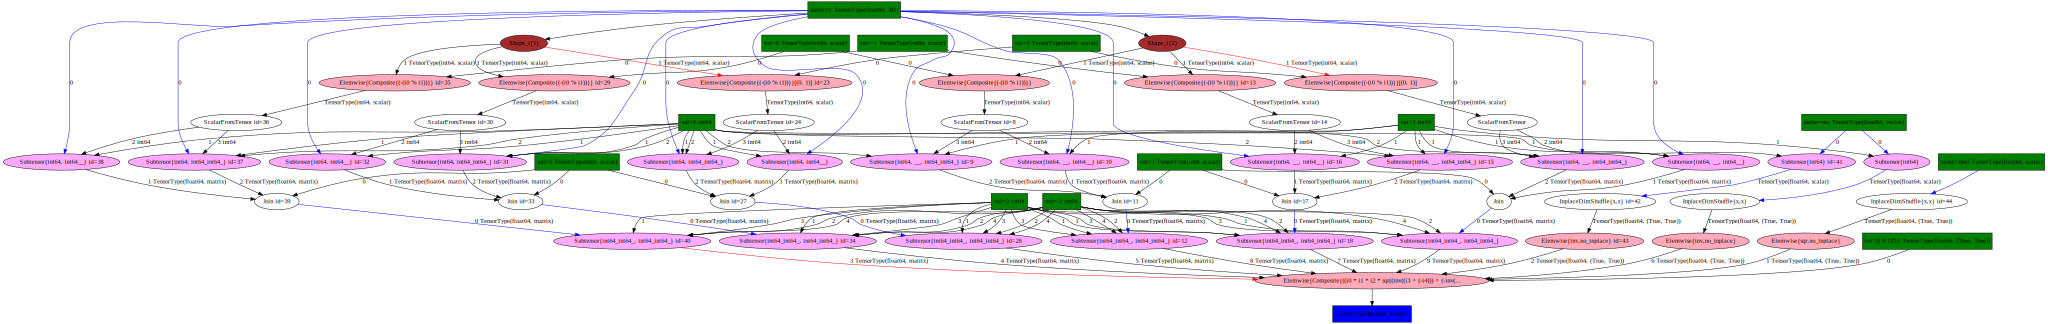

In [62]:
Q2b=fun(hbar_s,mu_v,C)(debound(clone(theano_code(Qs2[ith,ith]),ro2,strict=False)))
Q2b_=function([hbar_s,mu_v,C],Q2b(hbar_s,mu_v,C))
SVG(pydotprint(Q2b_.maker.fgraph.outputs[0], return_image=True, format='svg'))

In [63]:
R0b=fun(hbar_s,mu_v,C)(debound(clone(theano_code(Rs[0,ith,ith]),ro2,strict=False)))
R1b=fun(hbar_s,mu_v,C)(debound(clone(theano_code(Rs[1,ith,ith]),ro2,strict=False)))

In [64]:
def Rb(hbar_s,mu_v,C): return stack([R0b(hbar_s,mu_v,C),R1b(hbar_s,mu_v,C)])
Rb_=function([hbar_s,mu_v,C],Rb(hbar_s,mu_v,C))

#### Density ####

In [65]:
D_ = function([C],debound(1/J(C).determinant()))

### Simulation ###

Using the expressions derived above we can generate efficient numerical functions which we use later in determining the motion of a particle in many worlds simultaneously.

We use the discrete difference approximation to Poirier's equations above for a numerical simulation of quantum motion in a small number of ``parallel'' worlds.

#### Classical Potential ####

In [66]:
x1,y1=scalars('x1','y1')

In [67]:
# Modified Coulomb interaction.
# The constant in the square root makes this continuously differentiable.
V = fun(x1,y1) (-1.0/sqrt((x1-y1)**2+0.000001))

In [68]:
# clone to compile vectorized numeric function
V_ = function([C],V(C[0],C[1]))

In [69]:
testgrid=0.1*(grid(2,500)-0.5)
testgrid.shape

In [70]:
V_(testgrid).shape

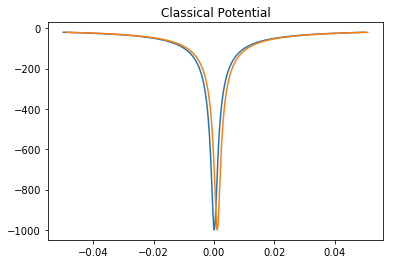

In [71]:
plot(testgrid[0][:,250],V_(testgrid)[:,250])
plot(testgrid[1][250,:]+0.001,V_(testgrid)[250,:])
title('Classical Potential')
show()

#### Classical Force ####

In [72]:
# symbolic gradient
Fx1 = fun(x1,y1) (-grad(V(x1,y1),x1))
Fy1 = fun(x1,y1) (-grad(V(x1,y1),y1))

In [73]:
F_ = function([C],stack([Fx1(C[0],C[1]),Fy1(C[0],C[1])]))

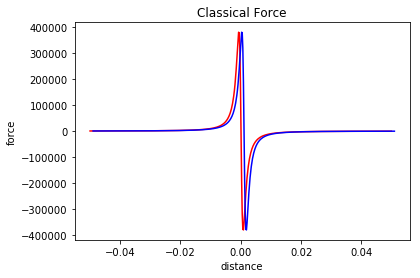

In [74]:
plot(testgrid[0][:,250],F_(testgrid)[0][:,250],
     color='red')
plot(testgrid[1][250,:]+0.001,F_(testgrid)[1][250,:],
     color='blue')
title('Classical Force')
xlabel('distance'); ylabel('force')
show()

### Initial Data ###

We introduce two widely separated fictitious worlds (not subject to dynamics) to the left and right to approximate open boundary conditions.

For example consider the spatial distribution of a Gaussian ensemble of one particle in  $N$ "parallel" worlds.

In [75]:
N = 20

#### Spatial Distribution

For example consider the spatial distribution of a Gaussian ensemble of one particle in  $N$ ``parallel'' worlds. Everything is in atomic units below, so $\hbar=1$.

In [76]:
bxy=2*(grid(2,N+2*B)-0.5); bxy.shape

In [77]:
xy=array(list(map(debound,bxy))); xy.shape

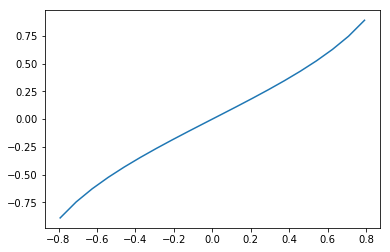

In [78]:
plot(xy[0][:,0],erfinv(xy[0][:,0]).eval()); show()

In [79]:
def gauss2(f,xy): return stack([f[0](xy[0])-50,f[1](xy[1])])

In [80]:
b0=gauss2([lambda x:50*erfinv(x),lambda x:erfinv(x)],bxy).eval()
b0 *= 10**12; b0[:,1:-1,1:-1] *= 10**-6; b0[:,2:-2,2:-2] *= 10**-6
b0.shape

In [81]:
p0 = array(list(map(debound,b0)))
p0.shape

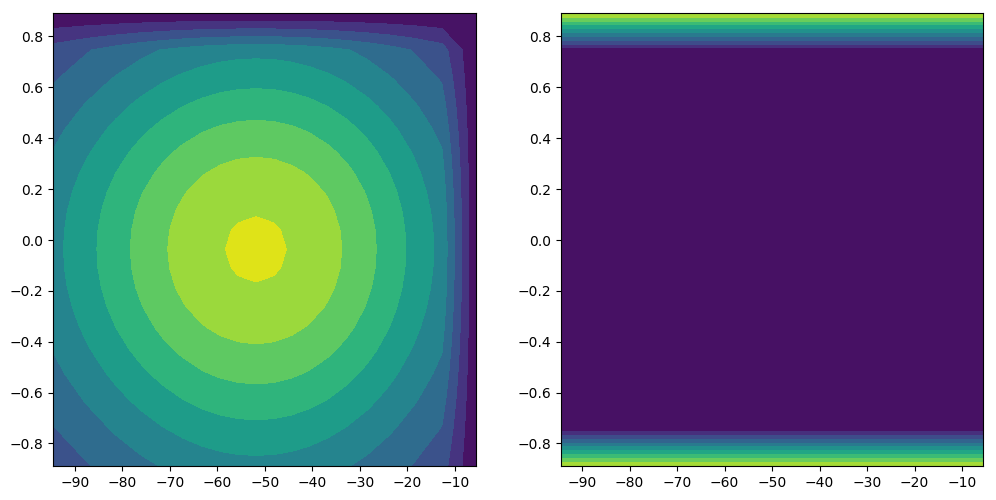

In [82]:
fig = figure(figsize=(12,6),dpi=100)
ax1=fig.add_subplot(121)
#ax1.set_aspect('equal')
ax1.contourf(p0[0],p0[1],D_(b0),10)
ax2=fig.add_subplot(122)
#ax2.set_aspect('equal')
ax2.contourf(p0[0],p0[1],Q2b_(1,[1,1],b0),10)
show()

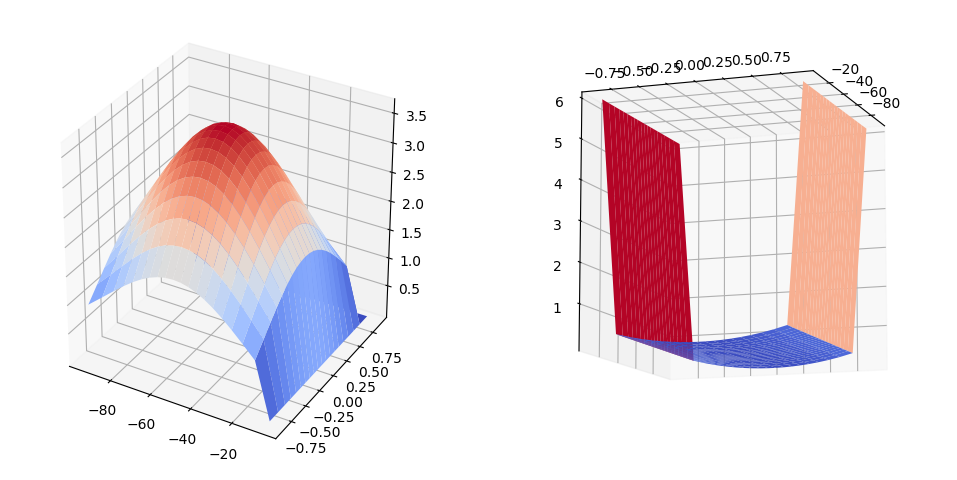

In [83]:
fig = figure(figsize=(12,6),dpi=100)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
# Plot the surface
ax1.plot_surface(p0[0], p0[1], D_(b0), cmap=coolwarm, linewidth=0, antialiased=True)
#ax1.view_init(10, 30)
ax2.plot_surface(p0[0], p0[1], Q2b_(1,[1,1],b0), cmap=coolwarm, linewidth=0, antialiased=True)
ax2.view_init(-10, 20)
show()

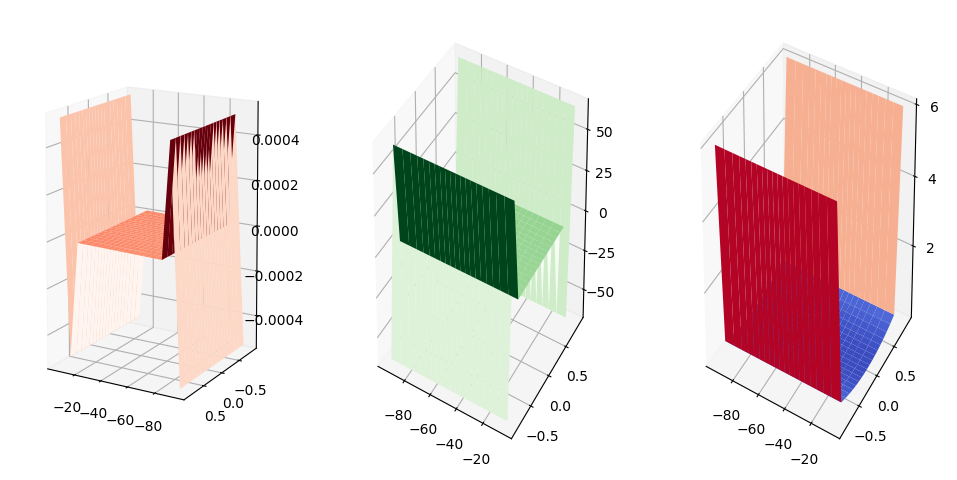

In [84]:
fig = figure(figsize=(12,6),dpi=100)
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')
# Plot the surface
ax1.plot_surface(p0[0], p0[1], Rb_(1,[1,1],b0)[0], cmap=Reds, linewidth=0, antialiased=True)
ax1.view_init(10, 120)
ax2.plot_surface(p0[0], p0[1], Rb_(1,[1,1],b0)[1], cmap=Greens, linewidth=0, antialiased=True)
#ax2.view_init(10, 240)
ax3.plot_surface(p0[0], p0[1], Q2b_(1,[1,1],b0), cmap=coolwarm, linewidth=0, antialiased=True)
#ax3.view_init(10, 20)
show()

We will use numeric functions based on the simplified sympy expressions for the quantum potential and force in the following simulation.

#### Distribution of Velocity ####
The electron ensemble approachs the proton ensemble with the same initial velocity in each world.

In [85]:
#v0=full(b0.shape,0.0,config.floatX)
#v0=array(meshgrid(array([1.0 for i in range(N+2*B)],config.floatX),array([0.0 for i in range(N+2*B)],config.floatX)))
v0=array(meshgrid(array([0.001 for i in range(N+2*B)],config.floatX),array([0.0 for i in range(N+2*B)],config.floatX)))


#### Acceleration ####

In [86]:
def boundary2(s): return stack([boundary0(s[i]) for i in dim])

In [87]:
def debound2(s): return stack([debound(s[i]) for i in dim])

In [88]:
def F(C): return stack([
            Fx1(C[0],C[1]),
            Fy1(C[0],C[1])])

In [89]:
def A(hbar,mu,x):
    return shape_padright(1/mu,2)*boundary2(F(debound2(x)) + Rb(hbar,mu,x))

#### Step Size Controller ####
Continuous integrating step size controller \cite{hairer2005}

In [90]:
def G(a,v):
    alpha = 0.0 # sensitivity
    eps = 1e-12
    g1 = sum(a*v)
    g2 = sum(v**2)
    #print g1.eval(),g2.eval()
    return switch(eq(g2,0),1/eps,-alpha*g1/g2)

#### Integration ####
Integrate using the Störmer–Verlet algorithm with adaptive step size.

In [91]:
mu = array([1.0,1836.0])  # mass
hbar = 1.0 # Planck's constant
rho = shared(asarray(1.0, config.floatX),'rho')
ds = scalar('ds')
dt = ds/rho
t = shared(asarray(0.0, config.floatX))
x = shared(b0)

In [92]:
a0 = A(hbar,mu,x).eval()

In [93]:
a = shared(a0)
v = shared(v0)
x_new = x+v*dt+0.5*a*dt**2
a_new = A(hbar,mu,x_new)
v_new = v+0.5*a*dt+0.5*a_new*dt

In [94]:
VerletStep = function([ds],t, updates=[
    (rho, rho + G(a_new,v_new)*dt ),
    (x, x_new ),
    (v, v_new ),
    (a, a_new ),
    (t, t + dt)
],allow_input_downcast=True)

#### Energy ####

In [95]:
KU1 = 0.5*sum(mu[0]*v[0]**2+mu[1]*v[1]**2)  # total kinetic energy
PU1 = sum(debound(V(x[0],x[1])))             # total classical potential
QU1 = sum(Q2b(hbar,mu,x))            # total quantum potential

In [96]:
E_ = function([],[KU1,PU1,QU1])

In [97]:
E_()

[array(0.00028800000000000375),
 array(-13.28644074459245),
 array(0.25932522488206955)]

In [98]:
crossing=function([],min([debound(d(-1,x[0],0)),debound(d(-1,x[1],1))])<0)

In [99]:
t_start = 0.0; t_end = 2000.0;
t_samples = 200; x_samples = N;

t_sample = t_end/t_samples
x_sample = __builtin__.max(1,int(N)//int(x_samples))
x_start = __builtin__.max(0,int(N-x_samples*x_sample)//int(2))
XS = array(range(B+x_start,B+N-x_start,x_sample))
#ds0 = 0.0001 # N=10 # initial step size
ds0 = 2.5e-06 # 1e-05 # # N=20 # initial step size
dsn = 1 # initial step size divider

In [100]:
while True:
    try: # step size
        ds = ds0/dsn
        # initial values
        rho0 = 1.0
        rho.set_value(rho0)
        t.set_value(t_start)
        x.set_value(b0)
        v.set_value(v0)
        a.set_value(a0)
        # recording
        T = [t_start]
        Rho = select({t_start:rho.get_value().item()})
        XX = select({t_start:x.get_value()[:,XS][:,:,XS]})
        XV = select({t_start:v.get_value()[:,XS][:,:,XS]})
        [KK,PP,QQ] = E_()
        E1 = KK+PP+QQ  # total energy
        TK = select({t_start:KK})
        TP = select({t_start:PP})
        TQ = select({t_start:QQ})
        E = select({t_start:E1})
        try:
            t0 = t.get_value().item()
            while t0<t_end:
                t1 = t0 + t_sample
                print "t =", t0, "t1 =",t1,"rho =", rho0, "E1 =",E1
                sys.stdout.flush()
                while t0<t1:
                    #print "t =", t0, "t1 =",t1,"rho =", rho0, "E1 =",E1
                    rho0 = rho.get_value().item()
                    if rho0 > 100 or rho0 < 0.01:
                        raise ValueError("Step control failed at %s. rho=%s"%(t0,rho0))
                    t0 = VerletStep(ds).item()
                if crossing(): raise ValueError("crossing at %s",t0)
                # Check total energy conservation
                [KK,PP,QQ] = E_()
                E2 = KK+PP+QQ
                if abs(E1-E2)>0.01:
                    raise ValueError(
                        "Energy conservation bound failed at %s. Delta E:"\
                        "|%s| > 0.01."%(t0,E1-E2))
                E1 = E2
                T += [t0]
                XX[t0] = x.get_value()[:,XS][:,:,XS]
                XV[t0] = v.get_value()[:,XS][:,:,XS]
                Rho[t0] = rho.get_value().item()
                TK[t0] = KK; TP[t0] = PP; TQ[t0] = QQ; E[t0] = E1
                t0 = t.get_value().item()
        except KeyboardInterrupt:
            print "Interrupted at %s ..."%(t0)
            T += [t0]
            XX[t0] = x.get_value()[:,XS][:,:,XS]
            XV[t0] = v.get_value()[:,XS][:,:,XS]
            Rho[t0] = rho.get_value().item(); TK[t0] = KK; TP[t0] = PP; TQ[t0] = QQ; E[t0] = E1
        tmax = t0
        break
    except ValueError as msg:
        print msg
        tmax = t0
        #break
        dsn = dsn + 1
        print "Trying a shorter initial step size: %s."%(ds0/dsn)
        continue
T=array(T)
print "t =", tmax

t = 0.0 t1 = 10.0 rho = 1.0 E1 = -13.0268275197


t = 10.0000199998 t1 = 20.0000199998 rho = 1.0 E1 = -13.0268275197


Energy conservation bound failed at 20.0000299994. Delta E:|0.0678399643063| > 0.01.
Trying a shorter initial step size: 5e-06.
t = 0.0 t1 = 10.0 rho = 1.0 E1 = -13.0268275197


t = 10.0000099997 t1 = 20.0000099997 rho = 1.0 E1 = -13.0268275198


t = 20.0000150007 t1 = 30.0000150007 rho = 1.0 E1 = -13.026828438


t = 30.0000200039 t1 = 40.0000200039 rho = 1.0 E1 = -13.0268284378


t = 40.0000250071 t1 = 50.0000250071 rho = 1.0 E1 = -13.0268287079


t = 50.0000300103 t1 = 60.0000300103 rho = 1.0 E1 = -13.0268272374


t = 60.0000350134 t1 = 70.0000350134 rho = 1.0 E1 = -13.0268266995


t = 70.0000400166 t1 = 80.0000400166 rho = 1.0 E1 = -13.0268258168


t = 80.0000450198 t1 = 90.0000450198 rho = 1.0 E1 = -13.0268251105


t = 90.000050023 t1 = 100.000050023 rho = 1.0 E1 = -13.026825149


t = 100.000055026 t1 = 110.000055026 rho = 1.0 E1 = -13.0268252628


t = 110.000060029 t1 = 120.000060029 rho = 1.0 E1 = -13.0268253201


t = 120.000065032 t1 = 130.000065032 rho = 1.0 E1 = -13.0268255898


t = 130.00007503 t1 = 140.00007503 rho = 1.0 E1 = -13.0268239386


t = 140.000085005 t1 = 150.000085005 rho = 1.0 E1 = -13.026823388


t = 150.000094979 t1 = 160.000094979 rho = 1.0 E1 = -13.0268274284


t = 160.000104954 t1 = 170.000104954 rho = 1.0 E1 = -13.0268274684


t = 170.000114929 t1 = 180.000114929 rho = 1.0 E1 = -13.0268289552


t = 180.000124904 t1 = 190.000124904 rho = 1.0 E1 = -13.0268294729


t = 190.000134878 t1 = 200.000134878 rho = 1.0 E1 = -13.0268307508


t = 200.000144853 t1 = 210.000144853 rho = 1.0 E1 = -13.0268288523


t = 210.000154828 t1 = 220.000154828 rho = 1.0 E1 = -13.0268308267


t = 220.000164803 t1 = 230.000164803 rho = 1.0 E1 = -13.0267788088


t = 230.000174778 t1 = 240.000174778 rho = 1.0 E1 = -13.0268319917


t = 240.000184752 t1 = 250.000184752 rho = 1.0 E1 = -13.0268221655


t = 250.000194727 t1 = 260.000194727 rho = 1.0 E1 = -13.0268338473


Energy conservation bound failed at 260.000199702. Delta E:|-0.0115435242266| > 0.01.
Trying a shorter initial step size: 3.33333333333e-06.
t = 0.0 t1 = 10.0 rho = 1.0 E1 = -13.0268275197


t = 10.0000066665 t1 = 20.0000066665 rho = 1.0 E1 = -13.0268275195


t = 20.0000133324 t1 = 30.0000133324 rho = 1.0 E1 = -13.026827519


t = 30.0000199951 t1 = 40.0000199951 rho = 1.0 E1 = -13.0268275187


t = 40.0000266579 t1 = 50.0000266579 rho = 1.0 E1 = -13.0268275185


t = 50.0000333206 t1 = 60.0000333206 rho = 1.0 E1 = -13.0268275179


t = 60.0000399833 t1 = 70.0000399833 rho = 1.0 E1 = -13.0268275173


t = 70.0000433255 t1 = 80.0000433255 rho = 1.0 E1 = -13.0268275173


t = 80.0000466762 t1 = 90.0000466762 rho = 1.0 E1 = -13.026827517


t = 90.000050027 t1 = 100.000050027 rho = 1.0 E1 = -13.0268275178


t = 100.000053378 t1 = 110.000053378 rho = 1.0 E1 = -13.0268275176


t = 110.000056728 t1 = 120.000056728 rho = 1.0 E1 = -13.0268275173


t = 120.000060079 t1 = 130.000060079 rho = 1.0 E1 = -13.0268275173


t = 130.000063421 t1 = 140.000063421 rho = 1.0 E1 = -13.0268275169


t = 140.000070063 t1 = 150.000070063 rho = 1.0 E1 = -13.0268275167


t = 150.000076704 t1 = 160.000076704 rho = 1.0 E1 = -13.0268275174


t = 160.000083346 t1 = 170.000083346 rho = 1.0 E1 = -13.0268275182


t = 170.000089987 t1 = 180.000089987 rho = 1.0 E1 = -13.0268275178


t = 180.000096628 t1 = 190.000096628 rho = 1.0 E1 = -13.0268274834


t = 190.00010327 t1 = 200.00010327 rho = 1.0 E1 = -13.0268275056


t = 200.000109911 t1 = 210.000109911 rho = 1.0 E1 = -13.0268275159


t = 210.000116553 t1 = 220.000116553 rho = 1.0 E1 = -13.0268274714


t = 220.000123194 t1 = 230.000123194 rho = 1.0 E1 = -13.0268264267


t = 230.000129836 t1 = 240.000129836 rho = 1.0 E1 = -13.0268268866


t = 240.000136477 t1 = 250.000136477 rho = 1.0 E1 = -13.0268205162


t = 250.000143118 t1 = 260.000143118 rho = 1.0 E1 = -13.026827514


t = 260.00014976 t1 = 270.00014976 rho = 1.0 E1 = -13.0268275156


t = 270.000156401 t1 = 280.000156401 rho = 1.0 E1 = -13.0268274302


t = 280.000163043 t1 = 290.000163043 rho = 1.0 E1 = -13.0268272378


t = 290.000169684 t1 = 300.000169684 rho = 1.0 E1 = -13.0268275088


t = 300.000176325 t1 = 310.000176325 rho = 1.0 E1 = -13.0268274657


t = 310.000182967 t1 = 320.000182967 rho = 1.0 E1 = -13.0268275071


t = 320.000189608 t1 = 330.000189608 rho = 1.0 E1 = -13.026826945


t = 330.00019625 t1 = 340.00019625 rho = 1.0 E1 = -13.0268275138


t = 340.000202891 t1 = 350.000202891 rho = 1.0 E1 = -13.0268275148


t = 350.000209533 t1 = 360.000209533 rho = 1.0 E1 = -13.0268274713


t = 360.000216174 t1 = 370.000216174 rho = 1.0 E1 = -13.0268274274


t = 370.000222815 t1 = 380.000222815 rho = 1.0 E1 = -13.0268273623


t = 380.000229457 t1 = 390.000229457 rho = 1.0 E1 = -13.0265383403


t = 390.000236098 t1 = 400.000236098 rho = 1.0 E1 = -13.0268133689


t = 400.00024274 t1 = 410.00024274 rho = 1.0 E1 = -13.0268246337


t = 410.000249381 t1 = 420.000249381 rho = 1.0 E1 = -13.0267722946


t = 420.000256022 t1 = 430.000256022 rho = 1.0 E1 = -13.0268068404


t = 430.000262664 t1 = 440.000262664 rho = 1.0 E1 = -13.0267953396


t = 440.000269305 t1 = 450.000269305 rho = 1.0 E1 = -13.0265373581


Energy conservation bound failed at 450.000272613. Delta E:|-0.275240023832| > 0.01.
Trying a shorter initial step size: 2.5e-06.
t = 0.0 t1 = 10.0 rho = 1.0 E1 = -13.0268275197


t = 10.0000025004 t1 = 20.0000025004 rho = 1.0 E1 = -13.0268275192


t = 20.0000050035 t1 = 30.0000050035 rho = 1.0 E1 = -13.0268275185


t = 30.0000075067 t1 = 40.0000075067 rho = 1.0 E1 = -13.0268275177


t = 40.0000100099 t1 = 50.0000100099 rho = 1.0 E1 = -13.0268275168


t = 50.0000125131 t1 = 60.0000125131 rho = 1.0 E1 = -13.0268275164


t = 60.0000150162 t1 = 70.0000150162 rho = 1.0 E1 = -13.0268275155


t = 70.0000200024 t1 = 80.0000200024 rho = 1.0 E1 = -13.0268275145


t = 80.0000249771 t1 = 90.0000249771 rho = 1.0 E1 = -13.0268275137


t = 90.0000299519 t1 = 100.000029952 rho = 1.0 E1 = -13.0268275129


t = 100.000034927 t1 = 110.000034927 rho = 1.0 E1 = -13.0268275132


t = 110.000039901 t1 = 120.000039901 rho = 1.0 E1 = -13.0268275126


t = 120.000044876 t1 = 130.000044876 rho = 1.0 E1 = -13.0268275121


t = 130.000049851 t1 = 140.000049851 rho = 1.0 E1 = -13.026827511


t = 140.000054826 t1 = 150.000054826 rho = 1.0 E1 = -13.0268275094


t = 150.0000598 t1 = 160.0000598 rho = 1.0 E1 = -13.0268275087


t = 160.000064775 t1 = 170.000064775 rho = 1.0 E1 = -13.0268275075


t = 170.00006975 t1 = 180.00006975 rho = 1.0 E1 = -13.0268275063


t = 180.000074725 t1 = 190.000074725 rho = 1.0 E1 = -13.0268274926


t = 190.000079699 t1 = 200.000079699 rho = 1.0 E1 = -13.0268272887


t = 200.000084674 t1 = 210.000084674 rho = 1.0 E1 = -13.0268275029


t = 210.000089649 t1 = 220.000089649 rho = 1.0 E1 = -13.0268270694


t = 220.000094624 t1 = 230.000094624 rho = 1.0 E1 = -13.0268274812


t = 230.000099598 t1 = 240.000099598 rho = 1.0 E1 = -13.0268274963


t = 240.000104573 t1 = 250.000104573 rho = 1.0 E1 = -13.0268237167


t = 250.000109548 t1 = 260.000109548 rho = 1.0 E1 = -13.0268274896


t = 260.000114523 t1 = 270.000114523 rho = 1.0 E1 = -13.0268265037


t = 270.000119497 t1 = 280.000119497 rho = 1.0 E1 = -13.0268274097


t = 280.000124472 t1 = 290.000124472 rho = 1.0 E1 = -13.0268273182


t = 290.000129447 t1 = 300.000129447 rho = 1.0 E1 = -13.0268216828


t = 300.000134422 t1 = 310.000134422 rho = 1.0 E1 = -13.0268215368


t = 310.000139396 t1 = 320.000139396 rho = 1.0 E1 = -13.0268272214


t = 320.000144371 t1 = 330.000144371 rho = 1.0 E1 = -13.0268273676


t = 330.000149346 t1 = 340.000149346 rho = 1.0 E1 = -13.0268267763


t = 340.000154321 t1 = 350.000154321 rho = 1.0 E1 = -13.0249231148


t = 350.000159295 t1 = 360.000159295 rho = 1.0 E1 = -13.0268261968


t = 360.00016427 t1 = 370.00016427 rho = 1.0 E1 = -13.0268139546


t = 370.000169245 t1 = 380.000169245 rho = 1.0 E1 = -13.0268270719


t = 380.00017422 t1 = 390.00017422 rho = 1.0 E1 = -13.0268182852


t = 390.000179194 t1 = 400.000179194 rho = 1.0 E1 = -13.0268155484


t = 400.000184169 t1 = 410.000184169 rho = 1.0 E1 = -13.0268268301


t = 410.000189144 t1 = 420.000189144 rho = 1.0 E1 = -13.0267522092


t = 420.000194119 t1 = 430.000194119 rho = 1.0 E1 = -13.0268266715


t = 430.000199093 t1 = 440.000199093 rho = 1.0 E1 = -13.0264377511


t = 440.000204068 t1 = 450.000204068 rho = 1.0 E1 = -13.0268246528


t = 450.000209043 t1 = 460.000209043 rho = 1.0 E1 = -13.0267967131


t = 460.000214018 t1 = 470.000214018 rho = 1.0 E1 = -13.026160969


t = 470.000218992 t1 = 480.000218992 rho = 1.0 E1 = -13.0268033645


t = 480.000223967 t1 = 490.000223967 rho = 1.0 E1 = -13.0267740641


t = 490.000228942 t1 = 500.000228942 rho = 1.0 E1 = -13.0267528683


t = 500.000233917 t1 = 510.000233917 rho = 1.0 E1 = -13.026643363


t = 510.000238891 t1 = 520.000238891 rho = 1.0 E1 = -13.0267331881


t = 520.000241548 t1 = 530.000241548 rho = 1.0 E1 = -13.025504365


Energy conservation bound failed at 530.00024175. Delta E:|-0.053237954835| > 0.01.
Trying a shorter initial step size: 2e-06.
t = 0.0 t1 = 10.0 rho = 1.0 E1 = -13.0268275197


t = 10.0000020007 t1 = 20.0000020007 rho = 1.0 E1 = -13.026827519


t = 20.0000059985 t1 = 30.0000059985 rho = 1.0 E1 = -13.0268275187


t = 30.0000099911 t1 = 40.0000099911 rho = 1.0 E1 = -13.0268275182


t = 40.0000119978 t1 = 50.0000119978 rho = 1.0 E1 = -13.0268275178


t = 50.0000140081 t1 = 60.0000140081 rho = 1.0 E1 = -13.0268275171


t = 60.0000160183 t1 = 70.0000160183 rho = 1.0 E1 = -13.0268275172


t = 70.0000200073 t1 = 80.0000200073 rho = 1.0 E1 = -13.0268275171


t = 80.0000239821 t1 = 90.0000239821 rho = 1.0 E1 = -13.0268275165


t = 90.0000279568 t1 = 100.000027957 rho = 1.0 E1 = -13.0268275158


t = 100.000031932 t1 = 110.000031932 rho = 1.0 E1 = -13.0268275151


t = 110.000035906 t1 = 120.000035906 rho = 1.0 E1 = -13.0268275147


t = 120.000039881 t1 = 130.000039881 rho = 1.0 E1 = -13.0268275135


t = 130.000043856 t1 = 140.000043856 rho = 1.0 E1 = -13.0268275125


t = 140.000047831 t1 = 150.000047831 rho = 1.0 E1 = -13.0268275118


t = 150.000051805 t1 = 160.000051805 rho = 1.0 E1 = -13.0268275111


t = 160.00005578 t1 = 170.00005578 rho = 1.0 E1 = -13.0268275108


t = 170.000059755 t1 = 180.000059755 rho = 1.0 E1 = -13.0268275108


t = 180.00006373 t1 = 190.00006373 rho = 1.0 E1 = -13.0268274975


t = 190.000067704 t1 = 200.000067704 rho = 1.0 E1 = -13.0268274985


t = 200.000071679 t1 = 210.000071679 rho = 1.0 E1 = -13.0268275085


t = 210.000075654 t1 = 220.000075654 rho = 1.0 E1 = -13.0268275078


t = 220.000079629 t1 = 230.000079629 rho = 1.0 E1 = -13.0268275043


t = 230.000083603 t1 = 240.000083603 rho = 1.0 E1 = -13.0268223132


t = 240.000087578 t1 = 250.000087578 rho = 1.0 E1 = -13.0268251348


t = 250.000091553 t1 = 260.000091553 rho = 1.0 E1 = -13.0268275035


t = 260.000095528 t1 = 270.000095528 rho = 1.0 E1 = -13.0268274986


t = 270.000099502 t1 = 280.000099502 rho = 1.0 E1 = -13.0268275084


t = 280.000103477 t1 = 290.000103477 rho = 1.0 E1 = -13.0268275045


t = 290.000107452 t1 = 300.000107452 rho = 1.0 E1 = -13.0268219177


t = 300.000111427 t1 = 310.000111427 rho = 1.0 E1 = -13.026827437


t = 310.000115401 t1 = 320.000115401 rho = 1.0 E1 = -13.0268274673


t = 320.000119376 t1 = 330.000119376 rho = 1.0 E1 = -13.0268221837


t = 330.000123351 t1 = 340.000123351 rho = 1.0 E1 = -13.0267273783


t = 340.000127326 t1 = 350.000127326 rho = 1.0 E1 = -13.0268273471


t = 350.0001313 t1 = 360.0001313 rho = 1.0 E1 = -13.0268274564


t = 360.000135275 t1 = 370.000135275 rho = 1.0 E1 = -13.0267776752


t = 370.00013925 t1 = 380.00013925 rho = 1.0 E1 = -13.0268098386


t = 380.000143225 t1 = 390.000143225 rho = 1.0 E1 = -13.0268270852


t = 390.000147199 t1 = 400.000147199 rho = 1.0 E1 = -13.026614213


t = 400.000151174 t1 = 410.000151174 rho = 1.0 E1 = -13.0268273932


t = 410.000155149 t1 = 420.000155149 rho = 1.0 E1 = -13.0268274284


t = 420.000159124 t1 = 430.000159124 rho = 1.0 E1 = -13.0268129439


t = 430.000163098 t1 = 440.000163098 rho = 1.0 E1 = -13.0268229661


t = 440.000167073 t1 = 450.000167073 rho = 1.0 E1 = -13.0268256579


t = 450.000171048 t1 = 460.000171048 rho = 1.0 E1 = -13.0268263541


t = 460.000175023 t1 = 470.000175023 rho = 1.0 E1 = -13.0268235959


t = 470.000178997 t1 = 480.000178997 rho = 1.0 E1 = -13.0268268986


t = 480.000182972 t1 = 490.000182972 rho = 1.0 E1 = -13.0268085478


t = 490.000186947 t1 = 500.000186947 rho = 1.0 E1 = -13.0268261547


t = 500.000190922 t1 = 510.000190922 rho = 1.0 E1 = -13.026823359


t = 510.000194896 t1 = 520.000194896 rho = 1.0 E1 = -13.026826663


t = 520.000198871 t1 = 530.000198871 rho = 1.0 E1 = -13.0266691994


t = 530.000202846 t1 = 540.000202846 rho = 1.0 E1 = -13.0267810517


t = 540.000206821 t1 = 550.000206821 rho = 1.0 E1 = -13.0268085436


t = 550.000210795 t1 = 560.000210795 rho = 1.0 E1 = -13.0267959027


t = 560.00021477 t1 = 570.00021477 rho = 1.0 E1 = -13.0262616842


t = 570.000218745 t1 = 580.000218745 rho = 1.0 E1 = -13.0265455898


t = 580.00022272 t1 = 590.00022272 rho = 1.0 E1 = -13.0266557671


Energy conservation bound failed at 590.000224694. Delta E:|-0.0993299709125| > 0.01.
Trying a shorter initial step size: 1.66666666667e-06.
t = 0.0 t1 = 10.0 rho = 1.0 E1 = -13.0268275197


t = 10.0000033329 t1 = 20.0000033329 rho = 1.0 E1 = -13.0268275187


t = 20.0000066623 t1 = 30.0000066623 rho = 1.0 E1 = -13.0268275178


t = 30.0000099917 t1 = 40.0000099917 rho = 1.0 E1 = -13.026827517


t = 40.0000116715 t1 = 50.0000116715 rho = 1.0 E1 = -13.0268275155


t = 50.0000133555 t1 = 60.0000133555 rho = 1.0 E1 = -13.026827515


t = 60.0000150396 t1 = 70.0000150396 rho = 1.0 E1 = -13.0268275141


t = 70.0000183647 t1 = 80.0000183647 rho = 1.0 E1 = -13.026827513


t = 80.0000216728 t1 = 90.0000216728 rho = 1.0 E1 = -13.0268275122


t = 90.0000249809 t1 = 100.000024981 rho = 1.0 E1 = -13.0268275112


t = 100.000028289 t1 = 110.000028289 rho = 1.0 E1 = -13.0268275113


t = 110.000031597 t1 = 120.000031597 rho = 1.0 E1 = -13.026827511


t = 120.000034905 t1 = 130.000034905 rho = 1.0 E1 = -13.0268275109


t = 130.000038213 t1 = 140.000038213 rho = 1.0 E1 = -13.0268275107


t = 140.000041521 t1 = 150.000041521 rho = 1.0 E1 = -13.0268275114


t = 150.000044829 t1 = 160.000044829 rho = 1.0 E1 = -13.0268275108


t = 160.000048137 t1 = 170.000048137 rho = 1.0 E1 = -13.0268275099


t = 170.000051446 t1 = 180.000051446 rho = 1.0 E1 = -13.0268275091


t = 180.000054754 t1 = 190.000054754 rho = 1.0 E1 = -13.0268275025


t = 190.000058062 t1 = 200.000058062 rho = 1.0 E1 = -13.0268275056


t = 200.00006137 t1 = 210.00006137 rho = 1.0 E1 = -13.0268274972


Step Density

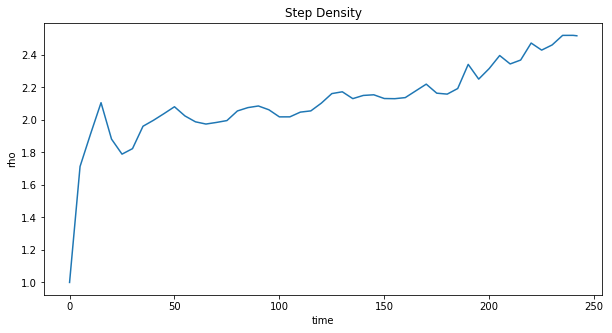

In [241]:
figure(figsize=(10,5))
plot(T, Rho[T])
title('Step Density')
xlabel('time'); ylabel('rho')
show()

#### Quantum Potential, Classical Potential and Kinetic Energy ####

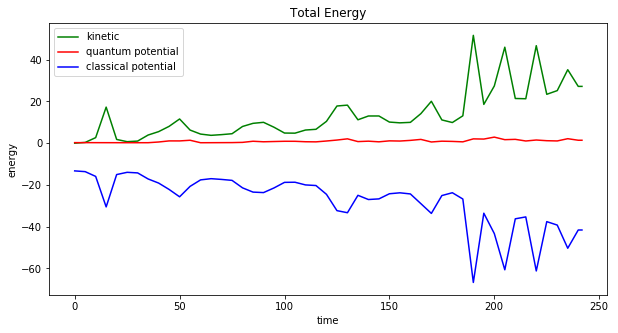

In [242]:
figure(figsize=(10,5))
plot(T, TK[T],color='green',label='kinetic')
plot(T, TQ[T],color='red',label='quantum potential')
plot(T, TP[T],color='blue',label='classical potential')
legend()
title('Total Energy')
xlabel('time'); ylabel('energy')
show()

#### Energy Conservation ####

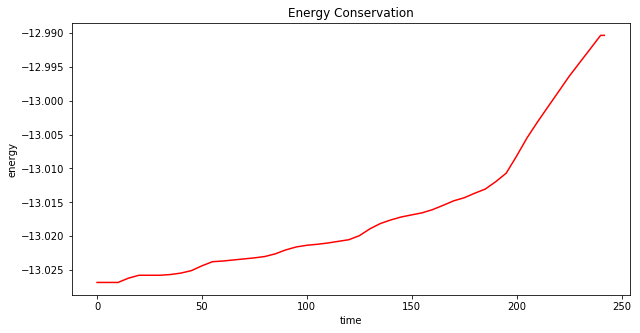

In [243]:
figure(figsize=(10,5))
plot(T, TK[T]+TP[T]+TQ[T],color='red')
title('Energy Conservation')
xlabel('time'); ylabel('energy')
show()

#### Trajectories ####
The trajectory of the particle in each world is shown below.  Notice how the trajectories do not cross, yet in some worlds the particle is scattered from the barrier while in others the particle tunnels across the barrier "pushed" by its counterpart in other worlds.

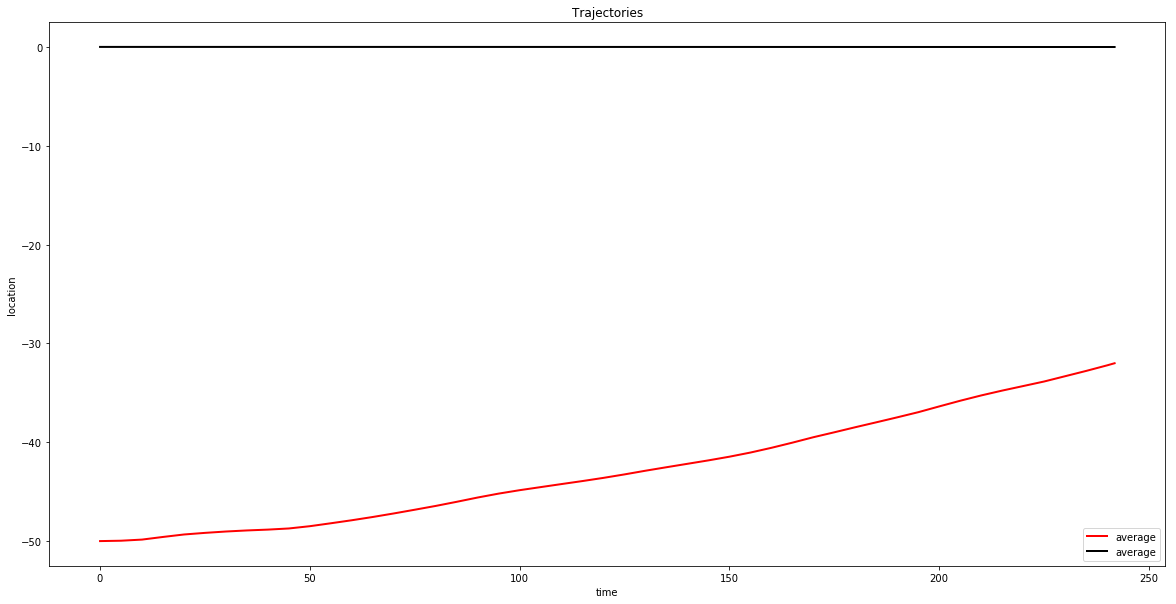

In [244]:
figure(figsize=(20,10))
plot(T, mean(XX[T][:,0],(1,2)), color='red',label='average',linewidth=2)
plot(T, mean(XX[T][:,1],(1,2)), color='black',label='average',linewidth=2)
legend()
title('Trajectories')
xlabel('time'); ylabel('location')
show()

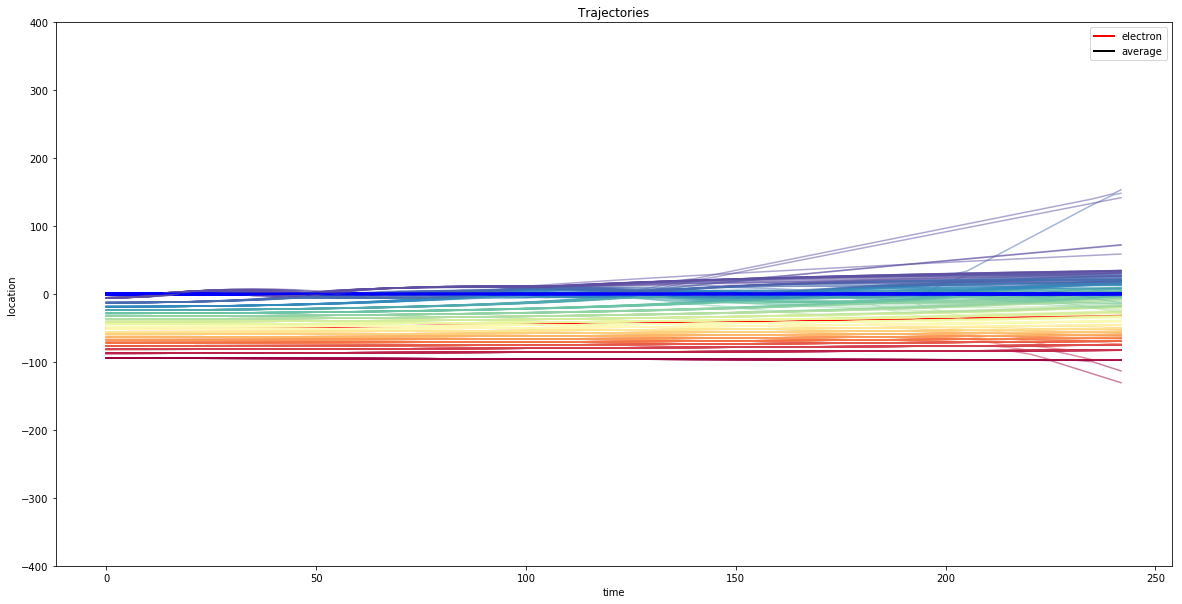

In [245]:
figure(figsize=(20,10))
plot(T, mean(XX[T][:,0],(1,2)), color='red',label='electron',linewidth=2)
plot(T, mean(XX[T][:,1],(1,2)), color='blue',label='proton',linewidth=2)
line_color = Spectral(linspace(0,1,len(XS)))
for i in range(len(XS)):
    for j in range(len(XS)):
        plot(T, XX[T][:,0,i,j],color=line_color[i],alpha=0.5)
        plot(T, XX[T][:,1,i,j],color='blue',alpha=0.5)
legend()
title('Trajectories')
xlabel('time'); ylabel('location')
#xlim(7750,8750)
ylim(-400,400)
show()

This picture reminds me of how cold anti-electrons and anti-protons must be in order to form anti-hydrogen.

Average velocity

In [246]:
mean(v.get_value()[0],(0,1))

In [247]:
from theano.tensor import min,max

In [248]:
min(v.get_value()[0],(0,1)).eval(),max(v.get_value()[0],(0,1)).eval()

(array(-2.0006310406464265), array(3.2576069289946488))

#### Final Distribution ####
The distribution at the end of the simulation shows the reflected and transmitted "wave packets" separating from each other.

In greater detail ...

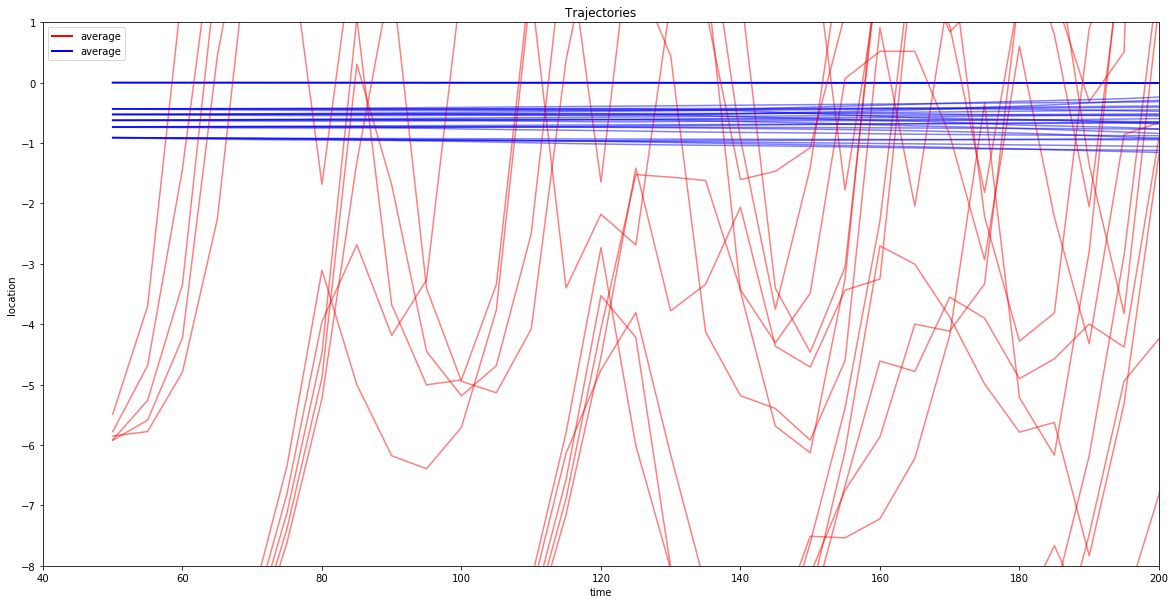

In [251]:
figure(figsize=(20,10))
plot(T, mean(XX[T][:,0],(1,2)), color='red',label='average',linewidth=2)
plot(T[10:], mean(XX[T[10:]][:,1],(1,2)), color='blue',label='average',linewidth=2)
line_color = Spectral(linspace(0,1,len(XS)))
xlim(40,200)
ylim(-8,1)
for i in range(15,20): #range(len(XS)):
    for j in range(0,5): #range(len(XS)):
        plot(T[10:], XX[T[10:]][:,0,i,j],color='red',alpha=0.5)
        plot(T[10:], XX[T[10:]][:,1,i,j],color='blue',alpha=0.5)
legend()
title('Trajectories')
xlabel('time'); ylabel('location')
show()

In [153]:
def update_graph(t):
    return graph.set_offsets((XX[t][0],XX[t][1]))
fig = figure(figsize=(10,5))
ax = axes()
ax.set_xlim((-500, 500))
ax.set_ylim(( -400, 400))
graph = ax.scatter([],[])
xlabel('particle 1 (electron)'); ylabel('particle 2 (proton)')
ani = animation.FuncAnimation(fig, update_graph, frames=T, interval=500)
close()
HTML(ani.to_html5_video())

In [0]:
graph.set_offset_position?

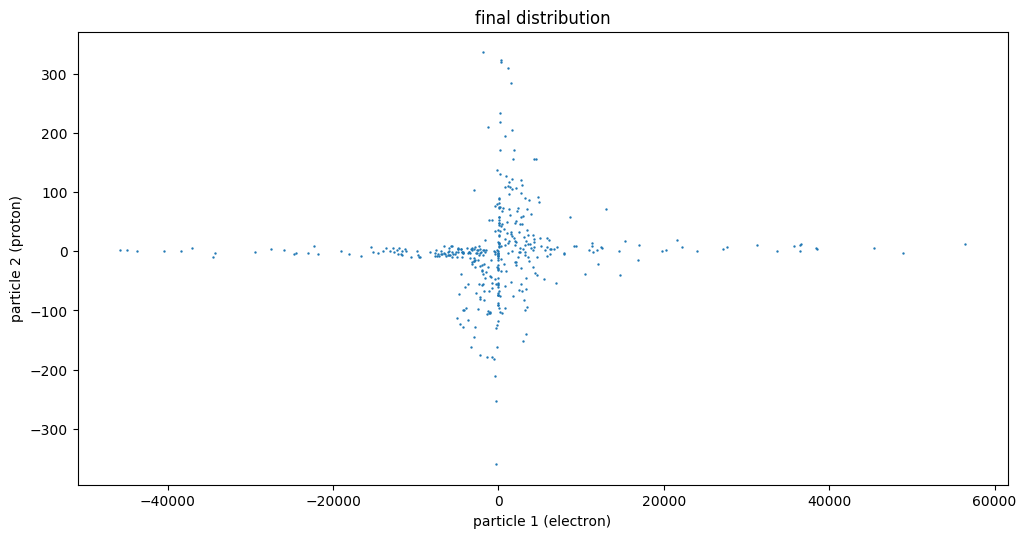

In [139]:
fig = figure(figsize=(12,6),dpi=100)
scatter(debound(x[0]).eval(),debound(x[1]).eval(),s=0.5)
title("final distribution")
xlabel('particle 1 (electron)'); ylabel('particle 2 (proton)')
show()

In [719]:
debound(x[0]).eval().shape,D_(x.eval()).shape

In [720]:
from matplotlib.pyplot import hist

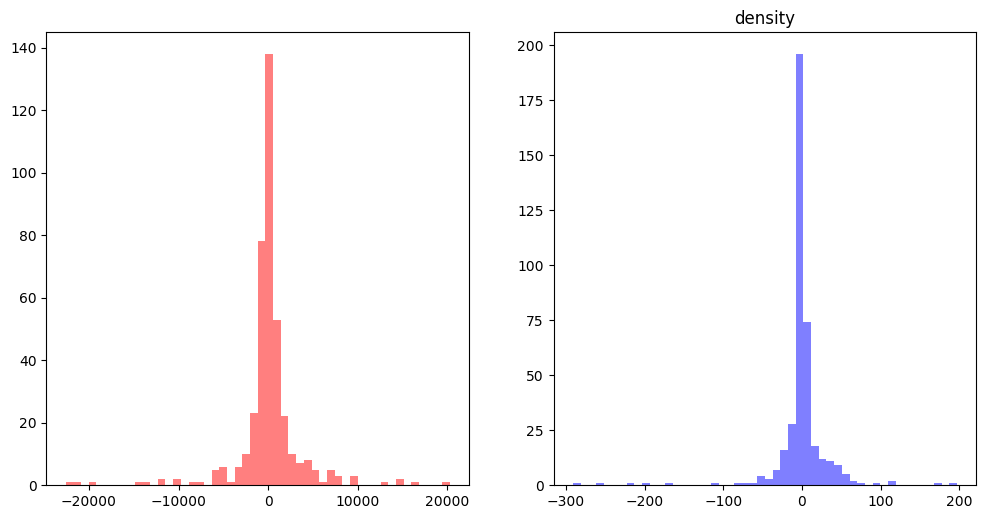

In [731]:
fig = figure(figsize=(12,6),dpi=100)
ax1=fig.add_subplot(121)
ax1.hist(debound(x[0]).eval().flatten(),50,color='red',alpha=0.5)
ax1=fig.add_subplot(122)
ax1.hist(debound(x[1]).eval().flatten(),50,color='blue',alpha=0.5)
title('density')
show()

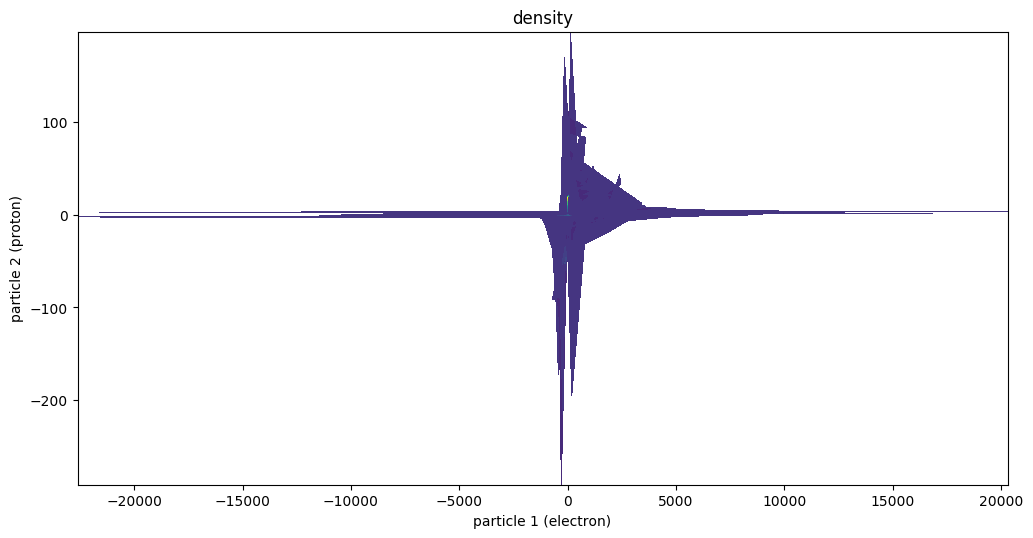

In [692]:
fig = figure(figsize=(12,6),dpi=100)
ax1=fig.add_subplot(111)
#ax1.set_aspect('equal')
ax1.contourf(debound(x[0]).eval(),debound(x[1]).eval(),D_(x.eval()),30)
title('density')
xlabel('particle 1 (electron)'); ylabel('particle 2 (proton)')
show()

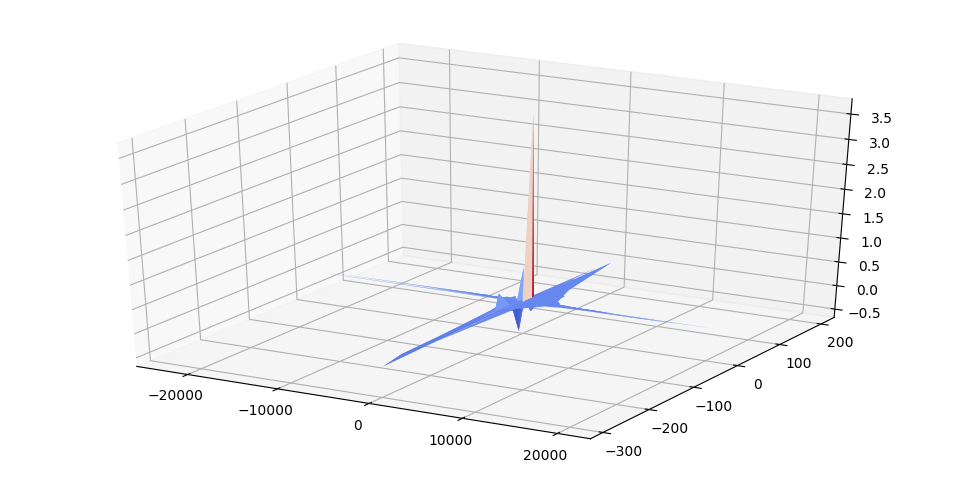

In [693]:
fig = figure(figsize=(12,6),dpi=100)
ax1 = fig.add_subplot(111, projection='3d')
# Plot the surface
ax1.plot_surface(debound(x[0]).eval(),debound(x[1]).eval(),D_(x.get_value()), cmap=coolwarm, linewidth=0, antialiased=True)
#ax1.view_init(50, 40)
show()

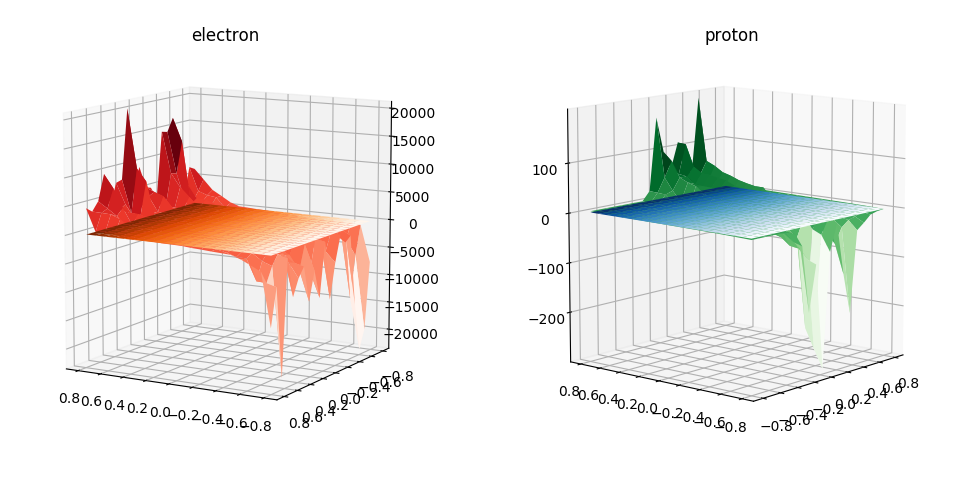

In [708]:
fig = figure(figsize=(12,6),dpi=100)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
# Plot the surface
p1=ax1.plot_surface(xy[0], xy[1], debound(x[0]).eval(), cmap=Reds, linewidth=0, antialiased=True, label='final')
p2=ax1.plot_surface(xy[0], xy[1], debound(b0[0]), cmap=Oranges, linewidth=0, antialiased=True, label='initial')
ax1.set_title('electron')
ax1.view_init(10, 120)
p3=ax2.plot_surface(xy[0], xy[1], debound(x[1]).eval(), cmap=Greens, linewidth=0, antialiased=True,label='final')
p4=ax2.plot_surface(xy[0], xy[1], debound(b0[1]), cmap=Blues, linewidth=0, antialiased=True, label='initial')
ax2.set_title('proton')
ax2.view_init(10, -140)
show()